<div style="border:2px solid black; padding:10px;">
    <h3>Nhóm 15</h3>
    <h1 style='color:red;text-align:center;font-size:30px'>Chủ đề: Phân tích về doanh thu phim<b></b></h1>
</div>


<h3>Danh sách thành viên</h3>
<li> Nguyễn Quốc Hưng - 21120464 </li>
<li> Đoàn Đức Hữu - 21120465 </li>
<li> Võ Minh Khuê - 21120486</li>
<li> Hồ Trọng Lễ - 21120494</li>


<h1 style='color:blue;text-align:center;font-size:30px'><b>Phần II</b></h1>


# Import thư viện


In [1098]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV

In [1099]:
import sys
sys.executable

'c:\\Users\\dhuu2\\AppData\\Local\\Programs\\Python\\Python311\\python.exe'

## Đọc file 'processed_data' vào dataframe df


In [1100]:
movies_df = pd.read_csv('./data/processed/processed_data.csv')
movies_df.head(10)

,title,domestic_revenue,world_revenue,distributor,opening_revenue,MPAA,genres,running_time,in_release,release_date
0,Batman Returns,162831698,266831698,Warner Bros.,45687711.0,PG-13,"Action,Crime,Fantasy",126.0,196.0,1992-06-19
1,Evolution,38345494,98376292,DreamWorks Distribution,13408351.0,PG-13,"Comedy,Sci-Fi",101.0,207.0,2001-06-08
2,Jumanji,100475249,100475249,Sony Pictures Entertainment (SPE),11084370.0,PG,"Adventure,Comedy,Family,Fantasy",104.0,383.0,1995-12-15
3,The American President,60079496,60079496,Sony Pictures Entertainment (SPE),10014558.0,PG-13,"Comedy,Drama,Romance",114.0,411.0,1995-11-17
4,Mulholland Drive,7220243,20117339,Universal Pictures,587591.0,R,"Drama,Mystery,Thriller",147.0,450.0,2001-10-08
5,Tombstone,56505065,56505065,Walt Disney Studios Motion Pictures,6454752.0,R,"Biography,Drama,History,Western",130.0,373.0,1993-12-24
6,Heart and Souls,16589540,16589540,Universal Pictures,4322250.0,PG-13,"Comedy,Drama,Fantasy,Romance",104.0,141.0,1993-08-13
7,The Phantom of the Opera,51268815,154648887,Warner Bros.,4001890.0,PG-13,"Drama,Musical,Romance,Thriller",143.0,375.0,2004-12-22
8,The Brady Bunch Movie,46576136,46576136,Paramount Pictures,14827066.0,PG-13,Comedy,90.0,318.0,1995-02-17
9,Teenage Mutant Ninja Turtles III,42273609,42273609,New Line Cinema,12419597.0,PG,"Action,Adventure,Comedy,Family,Fantasy,Sci-Fi",96.0,288.0,1993-03-19


## Vấn đề đặt ra :

- Dự đoán doanh thu phim đạt được ở thị trường nội địa


### Lựa chọn các đặc trưng


Ta sẽ chọn lọc ra các đặc trưng có thể ảnh hưởng doanh thu nội địa của một bộ phim , từ đó dùng các đặc trưng này để huấn luyện cho mô hình dự đoán doanh thu phim.
Các đặc trưng có khả năng tác đôngh đến doanh thu nội địa bao gồm:

- MPAA
- Running Time
- Genres
- Release Date
- In Release
- Distributor


## Tiền xử lý trước khi chạy mô hình


In [1101]:

# Tạo các đặc trưng mới dựa trên release_date
movies_df['release_date'] = pd.to_datetime(movies_df['release_date'])
movies_df['release_month'] = movies_df['release_date'].dt.month
movies_df['release_year'] = movies_df['release_date'].dt.year
movies_df = movies_df.drop('release_date', axis=1)

In [1102]:
# Giảm bớt sự ảnh hưởng của giá trị ngoại lệ
features = ['domestic_revenue', 'in_release']


for col in features:
    movies_df[col] = movies_df[col].apply(lambda x: np.log10(x))

In [1103]:
# Chuyển đổi dữ liệu phân loại trong cột genres thành dạng số bằng kỹ thuật 'One-Hot Encoding'
vectorizer = CountVectorizer()
vectorizer.fit(movies_df['genres'])
features = vectorizer.transform(movies_df['genres']).toarray()
genres = vectorizer.get_feature_names_out()


# Tạo một cột mới cho mỗi thể loại , giá trị trong mỗi cột tương ứng với sự xuất hiện của thể loại đó trong bộ phim (0,1).

for i, name in enumerate(genres):
    movies_df[name] = features[:, i]

movies_df.drop('genres', axis=1, inplace=True)


# Xóa cột có hơn 95% là giá trị 0
removed = 0
for col in movies_df.loc[:, 'action':'western'].columns:

    if (movies_df[col] == 0).mean() > 0.95:
        removed += 1
        movies_df.drop(col, axis=1, inplace=True)

print(removed)

11


In [1104]:


for col in ['distributor', 'MPAA']:
    le = LabelEncoder()
    movies_df[col] = le.fit_transform(movies_df[col])

Kiểm tra mối tương quan giữa các đặc trưng


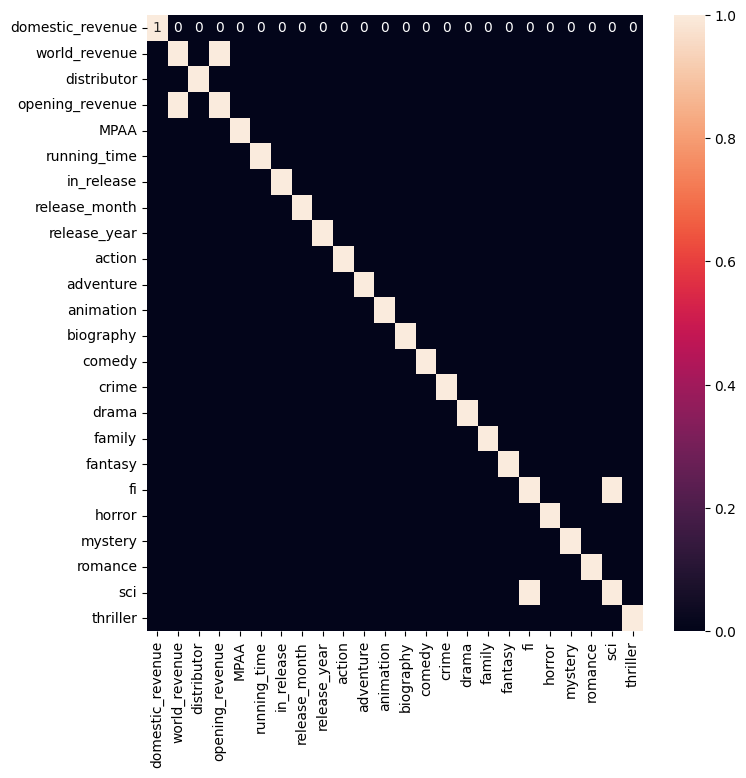

In [1105]:
numeric_cols = movies_df.select_dtypes(include=[np.number])

plt.figure(figsize=(8, 8))
sns.heatmap(numeric_cols.corr() > 0.8,
            annot=True,
            cbar=True)
plt.show()

Từ biểu đồ ta có thể quan sát được mối quan hệ giữa các đặc trưng. Những cặp đặc trưng có mối quan hệ cao với nhau sẽ được cân nhắc loại bỏ 1 đặc trưng để tránh hiện tượng đa cộng tuyến.

Đồng thời ta sẽ xóa bỏ các cột `Title`, `World_revenue` và `Openning_revenue` vì bài toán đặt ra là dự đoán doanh thu nội địa dựa trên các đặc trưng.


In [1106]:
features = movies_df.drop(
    ['title', 'domestic_revenue', 'world_revenue', 'opening_revenue', 'fi'], axis=1)
target = movies_df['domestic_revenue'].values

Chia tập dữ liệu thành hai tập dữ liệu với 1 tập dùng để huấn luyện cho mô hình và tập còn lại dùng để kiểm thử và đánh giá độ hiệu quả của mô hình.


In [1107]:


X_train, X_test, \
    Y_train, Y_test = train_test_split(features, target,
                                       test_size=0.2,
                                       random_state=0)
X_train.shape, X_test.shape

((3808, 20), (952, 20))

Chuẩn hóa dữ liệu


In [1108]:

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Các mô hình


<h3 style='color:#e28743;text-align:left;font-size:20px'><b>1. Linear Regression</b></h3>


Huấn luyện mô hình `Linear Regression` trên tập X_train và Y_train


In [1109]:
ln = LinearRegression().fit(X_train, Y_train)

Dùng mô hình để dự đoán trên tập `X_test`


In [1110]:
ln_pre = ln.predict(X_test)

Đỗ lỗi _MSE_ và _RMSE_ của mô hình so với `Y_test`


In [1111]:
ln_mse = mean_squared_error(Y_test, ln_pre)
ln_rmse = np.sqrt(ln_mse)
ln_mae = mean_absolute_error(Y_test, ln_pre)
print(ln_mse, '\t', ln_rmse, '\t', ln_mae)

0.2560706990559403 	 0.5060342864430634 	 0.3893063543250529


<h3 style='color:#e28743;text-align:left;font-size:20px'><b>2. Decision Tree Regression</b></h3>


In [1112]:
dt = DecisionTreeRegressor().fit(X_train, Y_train)

Dùng mô hình để dự đoán trên tập `X_test`


In [1113]:
dt_pred = dt.predict(X_test)

Đo độ lỗi `MSE`, `RMSE` và `MAE` của mô hình so với `Y_test`


In [1114]:
dt_mse = mean_squared_error(Y_test, dt_pred)
dt_rmse = np.sqrt(dt_mse)
dt_mae = mean_absolute_error(Y_test, dt_pred)
print(dt_mse, '\t', dt_rmse, '\t', dt_mae)

0.35525269370661655 	 0.5960307825159843 	 0.45378208716058016


<h3 style='color:#e28743;text-align:left;font-size:20px'><b>3. Random Forest Regression</b></h3>


In [1115]:
rf = RandomForestRegressor(max_depth=5).fit(X_train, Y_train)

Dùng mô hình để dự đoán trên tập `X_test`


In [1116]:
rf_pred = rf.predict(X_test)

Đo độ lỗi `MSE`,`RMSE` và `MAE` của mô hình so với `Y_test`


In [1117]:
rf_mse = mean_squared_error(Y_test, rf_pred)
rf_rmse = np.sqrt(rf_mse)
rf_mae = mean_absolute_error(Y_test, rf_pred)
print(rf_mse, '\t', rf_rmse, '\t', rf_mae)

0.2217409408750024 	 0.47089376814203265 	 0.3744826283012073


<h2 style='color:#e28743;text-align:center;font-size:25px'><b> Đánh giá mô hình</b></h2>


<h3 style='color:#21130d;text-align:left;font-size:20px'><b>1. Linear Regression</b></h3>


#### Cross-Validation


In [1118]:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

Tính độ lỗi trung bình


In [1119]:
scores = cross_val_score(ln, features, target,
                         scoring='neg_mean_squared_error', cv=cv)
print(scores, '\n', np.mean(scores))

[-0.2560707  -0.28583302 -0.2723138  -0.26768196 -0.26053657] 
 -0.2684872071771351


In [1120]:
ln_mse_scores = -scores
print(ln_mse_scores, '\n', np.mean(ln_mse_scores))

[0.2560707  0.28583302 0.2723138  0.26768196 0.26053657] 
 0.2684872071771351


In [1121]:
ln_rmse_scores = np.sqrt(ln_mse_scores)
print(ln_rmse_scores, '\n', np.mean(ln_rmse_scores))

[0.50603429 0.53463353 0.52183694 0.5173799  0.51042783] 
 0.5180624978075632


### Minh họa


Text(0.5, 0, 'Doanh thu nội địa ')

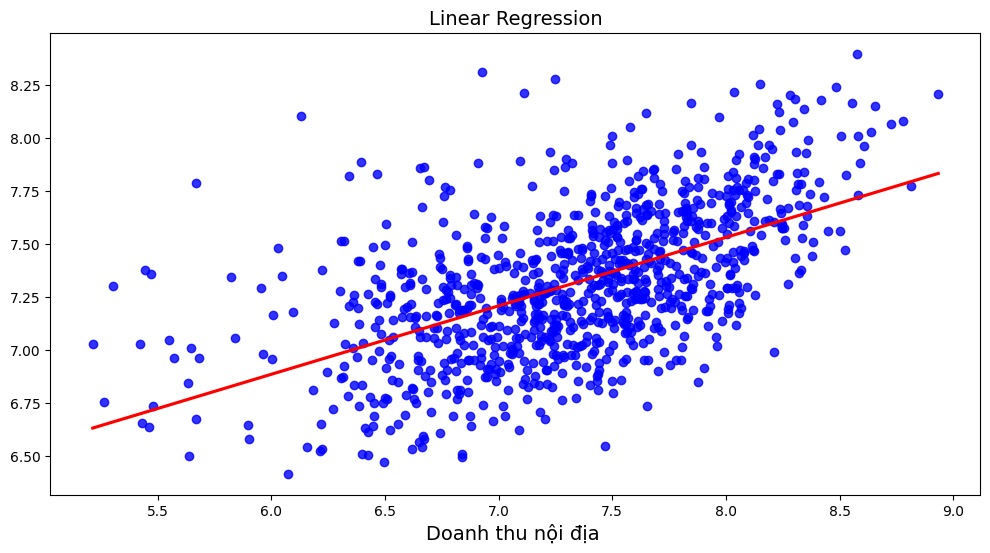

In [1122]:


plt.figure(figsize=(12, 6))
sns.regplot(x=Y_test, y=ln_pre, ci=None, scatter_kws={
            "color": "blue"}, line_kws={"color": "red"})
plt.title('Linear Regression', fontsize=14)
plt.xlabel('Doanh thu nội địa ', fontsize=14)

<h3 style='color:#21130d;font-size:20px'><b>2. Decision Tree Regression</b></h3>


#### Cross-Validation


In [1123]:
scores = cross_val_score(dt, X_train, Y_train,
                         scoring="neg_mean_squared_error", cv=5)
scores

array([-0.37602429, -0.35283444, -0.33464566, -0.38613275, -0.39613844])

Tính độ lỗi trung bình


In [1124]:
scores = -scores
scores.mean()

0.36915511702005566

<h3 style='color:#21130d;font-size:20px'><b>3. Random Forest Regression</b></h3>


#### Cross-Validation


In [1125]:
scores = cross_val_score(dt, X_train, Y_train,
                         scoring="neg_mean_squared_error", cv=5)
scores

array([-0.3849398 , -0.35155233, -0.3416217 , -0.39648082, -0.39398543])

#### Tính độ lỗi trung bình


In [1126]:
scores = -scores
scores.mean()

0.37371601469468074

### So sánh độ lỗi


In [1127]:

data = {
    'Linear Regression': [ln_rmse, ln_mse, ln_mae],
    'Decision Tree Regression': [dt_rmse, dt_mse, dt_mae],
    'Random Forest Regression': [rf_rmse, rf_mse, rf_mae]
}


metrics = ['RMSE', 'MSE', 'MAE']

e_df = pd.DataFrame(data, index=metrics)
e_df

,Linear Regression,Decision Tree Regression,Random Forest Regression
RMSE,0.506034,0.596031,0.470894
MSE,0.256071,0.355253,0.221741
MAE,0.389306,0.453782,0.374483


### Tinh chỉnh mô hình bằng siêu tham số


#### Mô hình Random Forest Regresion


In [1128]:
# Chọn các tham số
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [5, 10, 15, 20],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 3, 4],
    'min_samples_split': [2, 4, 6, 8, 10],
    'n_estimators': [5, 10, 15, 20]
}

In [1129]:
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)

In [1130]:
grid_search_rf.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(max_depth=5),
             param_grid={'bootstrap': [True, False],
                         'max_depth': [5, 10, 15, 20],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 3, 4],
                         'min_samples_split': [2, 4, 6, 8, 10],
                         'n_estimators': [5, 10, 15, 20]})

In [1131]:
print(grid_search_rf.best_params_)

{'bootstrap': False, 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 20}


#### Mô hình Decision Tree Regression


In [1132]:
# Chọn các tham số
param_grid = {
    'max_depth': [5, 10, 15, 20],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 3, 4],
    'min_samples_split': [2, 4, 6, 8],
}

In [1133]:
grid_search_dt = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5)

In [1134]:
grid_search_dt.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 3, 4],
                         'min_samples_split': [2, 4, 6, 8]})

### Chọn ra các siêu tham số tốt nhất


#### Mô hình Random Forest Regression


In [1135]:
grid_search_rf.best_params_

{'bootstrap': False,
 'max_depth': 15,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 20}

In [1136]:
rf = RandomForestRegressor(n_estimators=grid_search_rf.best_params_['n_estimators'], bootstrap=grid_search_rf.best_params_['bootstrap'],
                           max_depth=grid_search_rf.best_params_[
                               'max_depth'], max_features=grid_search_rf.best_params_['max_features'],
                           min_samples_leaf=grid_search_rf.best_params_['min_samples_leaf'], min_samples_split=grid_search_rf.best_params_['min_samples_split'])
rf.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=20)

In [1137]:
rf_pre = rf.predict(X_test)

Giá trị `MSE`, `RMSE`, và `MAE`


In [1138]:
rf_mse = mean_squared_error(Y_test, rf_pre)
rf_rmse = np.sqrt(rf_mse)
rf_mae = mean_absolute_error(Y_test, rf_pre)
print(rf_mse, '\t', rf_rmse, '\t', rf_mae)

0.18421720789916948 	 0.42920532137797346 	 0.340242049736312


##### Mô hình Decision Tree Regression


In [1139]:
grid_search_dt.best_params_

{'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 8}

In [1140]:
dt = DecisionTreeRegressor(max_depth=grid_search_dt.best_params_['max_depth'],
                           max_features=grid_search_dt.best_params_[
                               'max_features'],
                           min_samples_leaf=grid_search_dt.best_params_[
                               'min_samples_leaf'],
                           min_samples_split=grid_search_dt.best_params_['min_samples_split'])
dt.fit(X_train, Y_train)

DecisionTreeRegressor(max_depth=10, max_features='sqrt', min_samples_leaf=4,
                      min_samples_split=8)

In [1141]:
dt_pre = dt.predict(X_test)

Giá trị `MSE`,`RMSE` và `MAE`


In [1142]:
dt_mse = mean_squared_error(Y_test, dt_pre)
dt_rmse = np.sqrt(dt_mse)
dt_mae = mean_absolute_error(Y_test, dt_pre)
print(dt_mse, '\t', dt_rmse, '\t', dt_mae)

0.28103154562054594 	 0.5301240851164433 	 0.40421944883340116


### So sánh độ lỗi giữa các mô hình sau khi đã tinh chỉnh


In [1143]:

data = {
    'Linear Regression': [ln_rmse, ln_mse, ln_mae],
    'Decision Tree Regression': [dt_rmse, dt_mse, dt_mae],
    'Random Forest Regression': [rf_rmse, rf_mse, rf_mae]
}


metrics = ['RMSE', 'MSE', 'MAE']
ea_df = pd.DataFrame(data, index=metrics)
ea_df

e_df['Tuning'] = 'Before'
ea_df['Tuning'] = 'After'
combined_df = pd.concat([e_df, ea_df], axis=0)

combined_df.reset_index(inplace=True)
combined_df.rename(columns={'index': ' '}, inplace=True)
combined_df['Metric'] = pd.Categorical(
    combined_df[' '], ['MSE', 'RMSE', 'MAE'])

combined_df['Tuning'] = pd.Categorical(combined_df['Tuning'], categories=[
                                       'Before', 'After'], ordered=True)
combined_df.sort_values(['Tuning', 'Metric'], inplace=True)
final_df = combined_df.pivot(index='Tuning', columns=' ', values=[
                             'Linear Regression', 'Decision Tree Regression', 'Random Forest Regression'])


final_df = final_df.style.set_properties(**{'text-align': 'center'})

final_df

### KẾT LUẬN


`Random Forest Regression` là mô hình có `RMSE` và `MAE` nhỏ nhất nên được xem là mô hình dự đoán tốt nhất trong cả 3 mô hình.
